# Reconstrucción 3D
### Juan José Zuluaga Patiño

### Calibración de la cámara

Las fotos fueron tomadas con el celular de mi compañero Wilberson Osorio, la matriz intrínseca es la de su cámara, la cual ya habia calibrado anteriormente.

In [1]:
import numpy as np

mtx = np.array([
    [4.94196706e+04, 0.00000000e+00, 4.41554681e+02],
    [0.00000000e+00, 9.25708388e+04, 1.04911904e+02],
    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]
])

### Mejora de contraste y reducción de ruido

In [2]:
import cv2
import os

# Aplica CLAHE para mejorar el contraste y un filtro bilateral para reducir ruido.
def mejorar_contraste_y_reducir_ruido(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    enhanced_bgr = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)
    denoised = cv2.bilateralFilter(enhanced_bgr, d=9, sigmaColor=75, sigmaSpace=75)

    return denoised

for filename in os.listdir("../imagenes/raw/"):
        input_path = os.path.join("../imagenes/raw", filename)
        output_path = os.path.join("../imagenes/procesadas", filename)

        image = cv2.imread(input_path)
        if image is None:
            print(f"Error al leer: {input_path}, se omitirá.")
            continue

        processed_image = mejorar_contraste_y_reducir_ruido(image)

        cv2.imwrite(output_path, processed_image)
        print(f"Procesada y guardada: {output_path}")

Procesada y guardada: ../imagenes/procesadas/WhatsApp Image 2025-02-26 at 6.23.29 PM(2).jpeg
Procesada y guardada: ../imagenes/procesadas/WhatsApp Image 2025-02-26 at 6.23.32 PM(1).jpeg
Procesada y guardada: ../imagenes/procesadas/WhatsApp Image 2025-02-26 at 6.23.29 PM(1).jpeg
Procesada y guardada: ../imagenes/procesadas/WhatsApp Image 2025-02-26 at 6.23.28 PM(1).jpeg
Procesada y guardada: ../imagenes/procesadas/WhatsApp Image 2025-02-26 at 6.23.30 PM(3).jpeg
Procesada y guardada: ../imagenes/procesadas/WhatsApp Image 2025-02-26 at 6.23.31 PM.jpeg
Procesada y guardada: ../imagenes/procesadas/WhatsApp Image 2025-02-26 at 6.23.31 PM(2).jpeg
Error al leer: ../imagenes/raw/.ipynb_checkpoints, se omitirá.
Procesada y guardada: ../imagenes/procesadas/WhatsApp Image 2025-02-26 at 6.23.26 PM.jpeg
Procesada y guardada: ../imagenes/procesadas/WhatsApp Image 2025-02-26 at 6.23.29 PM.jpeg
Procesada y guardada: ../imagenes/procesadas/WhatsApp Image 2025-02-26 at 6.23.31 PM(3).jpeg
Procesada y guar

### Detección y emparejamiento de características:

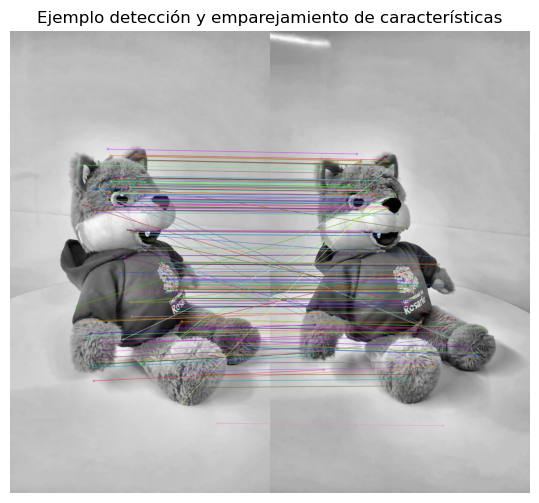

In [3]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

# Extrae las características de las dos imagenes usando SIFT y las corresponde usando FLANN
def extract_and_match_features(img1, img2, ratio_thresh=0.75):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # test ratio de Lowe's
    matches_knn = flann.knnMatch(des1, des2, k=2)
    good_matches = []
    for m, n in matches_knn:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])
    return kp1, des1, kp2, des2, good_matches, pts1, pts2

# Un ejemplo
img1_path = "../imagenes/procesadas/WhatsApp Image 2025-02-26 at 6.23.26 PM.jpeg"
img2_path = "../imagenes/procesadas/WhatsApp Image 2025-02-26 at 6.23.26 PM(1).jpeg"
    
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

kp1, des1, kp2, des2, good_matches, _, _ = extract_and_match_features(img1, img2)
matched_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
image_rgb = cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off") 
plt.title("Ejemplo detección y emparejamiento de características")
plt.show()

### Extracción de las matrizes escencial y fundamental, construcción de la geometria 3D

In [4]:
image_folder = "../imagenes/procesadas"
K = mtx

image_paths = sorted(glob.glob(os.path.join(image_folder, "*.jpeg")))
images = [cv2.imread(p) for p in image_paths]

img0 = images[0]
img1 = images[1]

kp0, des0, kp1, des1, good_matches, pts0, pts1 = extract_and_match_features(img0, img1)

# matriz fundamental con RANSAC
F, mask = cv2.findFundamentalMat(pts0, pts1, cv2.FM_RANSAC, 3.0, 0.99)
if F is None or F.shape != (3, 3):
    raise Exception("estimación de matriz fundamental falló.")

F

array([[-1.70524958e-07,  1.06423734e-06, -1.34651415e-03],
       [ 1.73096361e-06, -2.31142377e-07,  1.24746883e-02],
       [-7.76097278e-05, -1.38016752e-02,  1.00000000e+00]])

In [5]:
pts0_inliers = pts0[mask.ravel() == 1]
pts1_inliers = pts1[mask.ravel() == 1]

# computa la matriz escencial con la matriz instrínseca y la fundamental
E = K.T @ F @ K
E

array([[-4.16473761e+02,  4.86869467e+03, -6.47476300e+01],
       [ 7.91884756e+03, -1.98074228e+03,  1.22330085e+03],
       [ 1.41799201e+00, -1.23637666e+03,  3.25649151e-01]])

In [6]:
# recupera la traslación y rotación de la cámara
retval, R, t, mask_pose = cv2.recoverPose(E, pts0_inliers, pts1_inliers, K)
if retval == 0:
    raise Exception("recoverPose falló.")

R

array([[-0.91178767,  0.1126517 , -0.39490865],
       [ 0.12034798,  0.99271753,  0.00531645],
       [ 0.39263165, -0.04267898, -0.91870501]])

In [7]:
t

array([[0.25108846],
       [0.01303211],
       [0.96787641]])

In [8]:
# dadas las matrices de proyección de ambas cámaras y las correspondencias entre puntos 2D, los triangula y retorna puntos 3D
def triangulate_points(P1, P2, pts1, pts2):
    pts1_hom = pts1.T  
    pts2_hom = pts2.T
    points4d = cv2.triangulatePoints(P1, P2, pts1_hom, pts2_hom)
    points3d = points4d / points4d[3]
    points3d = points3d[:3].T 
    return points3d

# computa las matrices de proyección
P0 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
P1 = K @ np.hstack((R, t))

# triangula los puntos entre las dos imagenes
escena_3d = triangulate_points(P0, P1, pts0_inliers, pts1_inliers)
print("Por el momento, la escena tiene", len(escena_3d), "puntos")

Por el momento, la escena tiene 162 puntos


### Reconstrucción de la escena 3D con PYCOLMAP

In [1]:
import os
import argparse
import pycolmap

image_path="../imagenes/raw"
database_path="../colmap.db"
output_path="../output"

ops = pycolmap.SiftExtractionOptions()
ops.estimate_affine_shape = True
ops.domain_size_pooling = True

print("Extrayendo características...")
pycolmap.extract_features(
    database_path=database_path,
    image_path=image_path,
    sift_options=ops
)

ops2 = pycolmap.SiftMatchingOptions()
ops2.num_threads = 6


print("Correspondiendo características entre imagenes...")
pycolmap.match_exhaustive(
    database_path=database_path,
)

print("Ejecutando el mapeo incremental para la reconstrucción 3D...")
pycolmap.incremental_mapping(
    database_path=database_path,
    image_path=image_path,
    output_path=output_path,
)
print("Reconstrucción completa, guardada en:", output_path)

W20250226 19:09:09.719686 134513304039424 feature_extraction.cc:390] Your current options use the maximum number of threads on the machine to extract features. Extracting SIFT features on the CPU can consume a lot of RAM per thread for large images. Consider reducing the maximum image size and/or the first octave or manually limit the number of extraction threads. Ignore this warning, if your machine has sufficient memory for the current settings.
I20250226 19:09:09.720050 134511903901248 misc.cc:44] 
Feature extraction
I20250226 19:09:09.720573 134511692088896 sift.cc:717] Creating Covariant SIFT CPU feature extractor
I20250226 19:09:09.720658 134511681603136 sift.cc:717] Creating Covariant SIFT CPU feature extractor
I20250226 19:09:09.720672 134511595619904 sift.cc:717] Creating Covariant SIFT CPU feature extractor
I20250226 19:09:09.720711 134511585134144 sift.cc:717] Creating Covariant SIFT CPU feature extractor
I20250226 19:09:09.720793 134511564162624 sift.cc:717] Creating Covari

Extrayendo características...


I20250226 19:09:15.797034 134511419459136 feature_extraction.cc:258] Processed file [1/26]
I20250226 19:09:15.797071 134511419459136 feature_extraction.cc:261]   Name:            WhatsApp Image 2025-02-26 at 6.23.28 PM(3).jpeg
I20250226 19:09:15.797075 134511419459136 feature_extraction.cc:270]   Dimensions:      900 x 1600
I20250226 19:09:15.797079 134511419459136 feature_extraction.cc:273]   Camera:          #10 - SIMPLE_RADIAL
I20250226 19:09:15.797083 134511419459136 feature_extraction.cc:276]   Focal Length:    1920.00px
I20250226 19:09:15.797092 134511419459136 feature_extraction.cc:280]   Features:        4430
I20250226 19:09:15.875948 134511419459136 feature_extraction.cc:258] Processed file [2/26]
I20250226 19:09:15.875986 134511419459136 feature_extraction.cc:261]   Name:            WhatsApp Image 2025-02-26 at 6.23.27 PM(2).jpeg
I20250226 19:09:15.875990 134511419459136 feature_extraction.cc:270]   Dimensions:      900 x 1600
I20250226 19:09:15.875994 134511419459136 feature

Correspondiendo características entre imagenes...


I20250226 19:09:42.300136 134511903901248 feature_matching.cc:46] in 16.138s
I20250226 19:09:42.301937 134511903901248 timer.cc:91] Elapsed time: 0.269 [minutes]
I20250226 19:09:42.308558 134513304039424 incremental_pipeline.cc:237] Loading database
I20250226 19:09:42.309374 134513304039424 database_cache.cc:66] Loading cameras...
I20250226 19:09:42.309412 134513304039424 database_cache.cc:76]  26 in 0.000s
I20250226 19:09:42.309422 134513304039424 database_cache.cc:84] Loading matches...
I20250226 19:09:42.309805 134513304039424 database_cache.cc:89]  76 in 0.000s
I20250226 19:09:42.309813 134513304039424 database_cache.cc:105] Loading images...
I20250226 19:09:42.315178 134513304039424 database_cache.cc:153]  26 in 0.005s (connected 26)
I20250226 19:09:42.315201 134513304039424 database_cache.cc:164] Loading pose priors...
I20250226 19:09:42.315305 134513304039424 database_cache.cc:175]  0 in 0.000s
I20250226 19:09:42.315312 134513304039424 database_cache.cc:184] Building corresponde

Ejecutando el mapeo incremental para la reconstrucción 3D...


I20250226 19:09:42.502859 134513304039424 incremental_pipeline.cc:390] Registering image #20 (3)
I20250226 19:09:42.502890 134513304039424 incremental_pipeline.cc:393] => Image sees 230 / 2379 points
I20250226 19:09:42.676425 134513304039424 incremental_pipeline.cc:42] Retriangulation and Global bundle adjustment
I20250226 19:09:42.873988 134513304039424 incremental_pipeline.cc:390] Registering image #2 (4)
I20250226 19:09:42.874016 134513304039424 incremental_pipeline.cc:393] => Image sees 751 / 1466 points
I20250226 19:09:43.328397 134513304039424 incremental_pipeline.cc:42] Retriangulation and Global bundle adjustment
I20250226 19:09:43.522731 134513304039424 incremental_pipeline.cc:390] Registering image #5 (5)
I20250226 19:09:43.522758 134513304039424 incremental_pipeline.cc:393] => Image sees 222 / 647 points
I20250226 19:09:43.752305 134513304039424 incremental_pipeline.cc:42] Retriangulation and Global bundle adjustment
I20250226 19:09:43.858776 134513304039424 incremental_pipe

Reconstrucción completa, guardada en: ../output


### Visualización del modelo 3D

In [ ]:
#pip install numpy==1.24.0 --quiet
#pip install open3d --quiet

__Guarda la escena en formato .PLY__

In [5]:
import open3d as o3d
import pycolmap
import numpy as np

output_3d = "../output/3d_scene1.ply"
output_reconstruction="../output/1"
print(f"Cargando reconstrucción COLMAP desce {output_reconstruction}...")
reconstruction = pycolmap.Reconstruction(output_reconstruction)

points = []
colors = []
for point_id, point in reconstruction.points3D.items():
    points.append(point.xyz)
    colors.append(point.color / 255.0)  # Normalize to [0,1] for Open3D

points = np.array(points)
colors = np.array(colors)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

print(f"Loaded {len(points)} points from COLMAP reconstruction.")

o3d.io.write_point_cloud(output_3d, pcd, write_ascii=True)
print(f"Saved point cloud to {output_3d} (PLY format).")

Cargando reconstrucción COLMAP desce ../output/1...
Loaded 1135 points from COLMAP reconstruction.
Saved point cloud to ../output/3d_scene1.ply (PLY format).


__Muestra la escena__

In [10]:
import open3d as o3d

pcd = o3d.io.read_point_cloud("../output/3d_scene0.ply")
o3d.visualization.draw_geometries([pcd], lookat=(0, 0, 1), up=(-1, -1, 0), front=(-1, 0, 0), zoom=2)